## Notebook 03 – Evaluate Models

In this notebook we’ll:
- have a look at the training history of both stages
- run inference on both models using the test set
- for each model, plot some metrics such as
    - confusion matrices
    - class-wise and macro F1 scores
    - class-wise and top-3 classification accuracies

In [ ]:
import sys
sys.path.append('../scripts/')
sys.path.append('../scripts/training/')
from config import (TEST_DIR, MODEL_DIR, PLOT_DIR)
from model_utils import (create_regular_generator,
                         load_model_from_path)
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os

2025-04-25 13:10:14.189179: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 13:10:14.199898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745579414.212313  613114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745579414.215863  613114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745579414.225409  613114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def identify_columns(df):
    """Identify loss and metric columns in the DataFrame"""
    columns = df.columns
    
    # Try to find train and val loss columns
    train_loss = [col for col in columns if 'loss' in col.lower() and 'val' not in col.lower()]
    val_loss = [col for col in columns if 'val' in col.lower() and 'loss' in col.lower()]
    
    train_loss = train_loss[0] if train_loss else None
    val_loss = val_loss[0] if val_loss else None
    
    return train_loss, val_loss

def find_metric_columns(df, metric_name):
    """Find training and validation columns for the specified metric"""
    columns = df.columns
    
    # Find the training metric column
    train_metric_options = [
        metric_name,
        f"train_{metric_name}",
        f"{metric_name}"
    ]
    
    # Find the validation metric column
    val_metric_options = [
        f"val_{metric_name}",
        f"validation_{metric_name}"
    ]
    
    train_metric = None
    for option in train_metric_options:
        if option in columns:
            train_metric = option
            break
    
    val_metric = None
    for option in val_metric_options:
        if option in columns:
            val_metric = option
            break
    
    return train_metric, val_metric

def plot_training_histories(history_files, labels=None, metric_name='f1_macro', 
                           output_dir='plots', figsize=(18, 14), save_plot=False):
    """
    Plot training histories from CSV files with first history separate from others.
    Ensures equal y-limits for loss plots and metric plots.
    
    Parameters:
    -----------
    history_files : list
        List of paths to history CSV files (at least 2 files expected)
    labels : list, optional
        Labels for each history file. If None, filenames are used.
    metric_name : str, optional
        Metric to plot along with loss (default: 'f1_macro')
    output_dir : str, optional
        Directory to save plots (default: 'plots')
    figsize : tuple, optional
        Figure size (width, height) (default: (18, 14))
    save_plot : bool, optional
        Whether to save the plot to a file (default: True)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Load history files
    histories = []
    for file in history_files:
        try:
            df = pd.read_csv(file)
            # Add epoch column if not present
            if 'epoch' not in df.columns:
                df['epoch'] = np.arange(1, len(df) + 1)
            histories.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            histories.append(None)
    
    # Get labels
    if labels is None:
        labels = [Path(file).stem for file in history_files]
    
    # Ensure we have the same number of labels as histories
    if len(labels) < len(history_files):
        # Add default labels if needed
        additional_labels = [f"Model {i+1}" for i in range(len(labels), len(history_files))]
        labels.extend(additional_labels)
    
    # Create figure and subplots - 2 rows, 2 columns
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    # Create references to the four subplots
    ax_loss_first = axs[0, 0]    # Top-left for first model's loss
    ax_metric_first = axs[1, 0]  # Bottom-left for first model's metric
    ax_loss_others = axs[0, 1]   # Top-right for other models' loss
    ax_metric_others = axs[1, 1] # Bottom-right for other models' metric
    
    # Set titles and labels
    ax_loss_first.set_title(f'{labels[0]} - Training and Validation Loss', fontsize=16)
    ax_loss_first.set_ylabel('Loss', fontsize=14)
    
    ax_metric_first.set_title(f'{labels[0]} - Training and Validation {metric_name.upper()}', fontsize=16)
    ax_metric_first.set_xlabel('Epoch', fontsize=14)
    ax_metric_first.set_ylabel(metric_name.upper(), fontsize=14)
    
    ax_loss_others.set_title(f'Models Comparison - Training and Validation Loss', fontsize=16)
    ax_loss_others.set_ylabel('Loss', fontsize=14)
    
    ax_metric_others.set_title(f'Models Comparison - Training and Validation {metric_name.upper()}', fontsize=16)
    ax_metric_others.set_xlabel('Epoch', fontsize=14)
    ax_metric_others.set_ylabel(metric_name.upper(), fontsize=14)
    
    # Colors for different histories
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # First, collect all data to determine global min/max values for consistent y-axis limits
    loss_min, loss_max = float('inf'), float('-inf')
    metric_min, metric_max = float('inf'), float('-inf')
    
    for i, history_df in enumerate(histories):
        if history_df is None:
            continue
            
        # Identify columns
        train_loss, val_loss = identify_columns(history_df)
        train_metric, val_metric = find_metric_columns(history_df, metric_name)
        
        # Update loss min/max
        if train_loss:
            loss_min = min(loss_min, history_df[train_loss].min())
            loss_max = max(loss_max, history_df[train_loss].max())
        
        if val_loss:
            loss_min = min(loss_min, history_df[val_loss].min())
            loss_max = max(loss_max, history_df[val_loss].max())
            
        # Update metric min/max
        if train_metric:
            metric_min = min(metric_min, history_df[train_metric].min())
            metric_max = max(metric_max, history_df[train_metric].max())
        
        if val_metric:
            metric_min = min(metric_min, history_df[val_metric].min())
            metric_max = max(metric_max, history_df[val_metric].max())
    
    # Add some padding to the ranges (5% padding)
    loss_range = loss_max - loss_min
    loss_min -= loss_range * 0.05
    loss_max += loss_range * 0.05
    
    metric_range = metric_max - metric_min
    metric_min -= metric_range * 0.05
    metric_max += metric_range * 0.05
    
    # Plot first history
    if histories[0] is not None:
        first_df = histories[0]
        color = colors[0]
        
        # Identify columns
        train_loss, val_loss = identify_columns(first_df)
        train_metric, val_metric = find_metric_columns(first_df, metric_name)
        
        # Plot training and validation loss for first model
        if train_loss:
            ax_loss_first.plot(first_df['epoch'], first_df[train_loss], 
                            color=color, linestyle='-', marker='o', markersize=4, 
                            label='Train')
        
        if val_loss:
            ax_loss_first.plot(first_df['epoch'], first_df[val_loss], 
                            color=color, linestyle='--', marker='s', markersize=4, 
                            label='Validation')
        
        # Plot training and validation metric for first model
        if train_metric:
            ax_metric_first.plot(first_df['epoch'], first_df[train_metric], 
                                color=color, linestyle='-', marker='o', markersize=4, 
                                label='Train')
        
        if val_metric:
            ax_metric_first.plot(first_df['epoch'], first_df[val_metric], 
                                color=color, linestyle='--', marker='s', markersize=4, 
                                label='Validation')
    
    # Plot second and third histories (and any additional ones) together
    for i in range(1, len(histories)):
        history_df = histories[i]
        label = labels[i]
        
        if history_df is None:
            continue
        
        # Get color for this history
        color = colors[i % len(colors)]
        
        # Identify columns
        train_loss, val_loss = identify_columns(history_df)
        train_metric, val_metric = find_metric_columns(history_df, metric_name)
        
        # Plot training and validation loss
        if train_loss:
            ax_loss_others.plot(history_df['epoch'], history_df[train_loss], 
                              color=color, linestyle='-', marker='o', markersize=4, 
                              label=f'{label} - Train')
        
        if val_loss:
            ax_loss_others.plot(history_df['epoch'], history_df[val_loss], 
                              color=color, linestyle='--', marker='s', markersize=4, 
                              label=f'{label} - Val')
        
        # Plot training and validation metric
        if train_metric:
            ax_metric_others.plot(history_df['epoch'], history_df[train_metric], 
                                color=color, linestyle='-', marker='o', markersize=4, 
                                label=f'{label} - Train')
        
        if val_metric:
            ax_metric_others.plot(history_df['epoch'], history_df[val_metric], 
                                color=color, linestyle='--', marker='s', markersize=4, 
                                label=f'{label} - Val')
    
    # Set consistent y-limits for all loss plots and all metric plots
    ax_loss_first.set_ylim(loss_min, loss_max)
    ax_loss_others.set_ylim(loss_min, loss_max)
    
    ax_metric_first.set_ylim(metric_min, metric_max)
    ax_metric_others.set_ylim(metric_min, metric_max)
    
    # Add legends
    ax_loss_first.legend(loc='best', fontsize=12)
    ax_metric_first.legend(loc='best', fontsize=12)
    ax_loss_others.legend(loc='best', fontsize=12)
    ax_metric_others.legend(loc='best', fontsize=12)
    
    # Set grid
    ax_loss_first.grid(True, linestyle='--', alpha=0.7)
    ax_metric_first.grid(True, linestyle='--', alpha=0.7)
    ax_loss_others.grid(True, linestyle='--', alpha=0.7)
    ax_metric_others.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure if requested
    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f'training_history_split_{metric_name}.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_path}")
    
    return fig


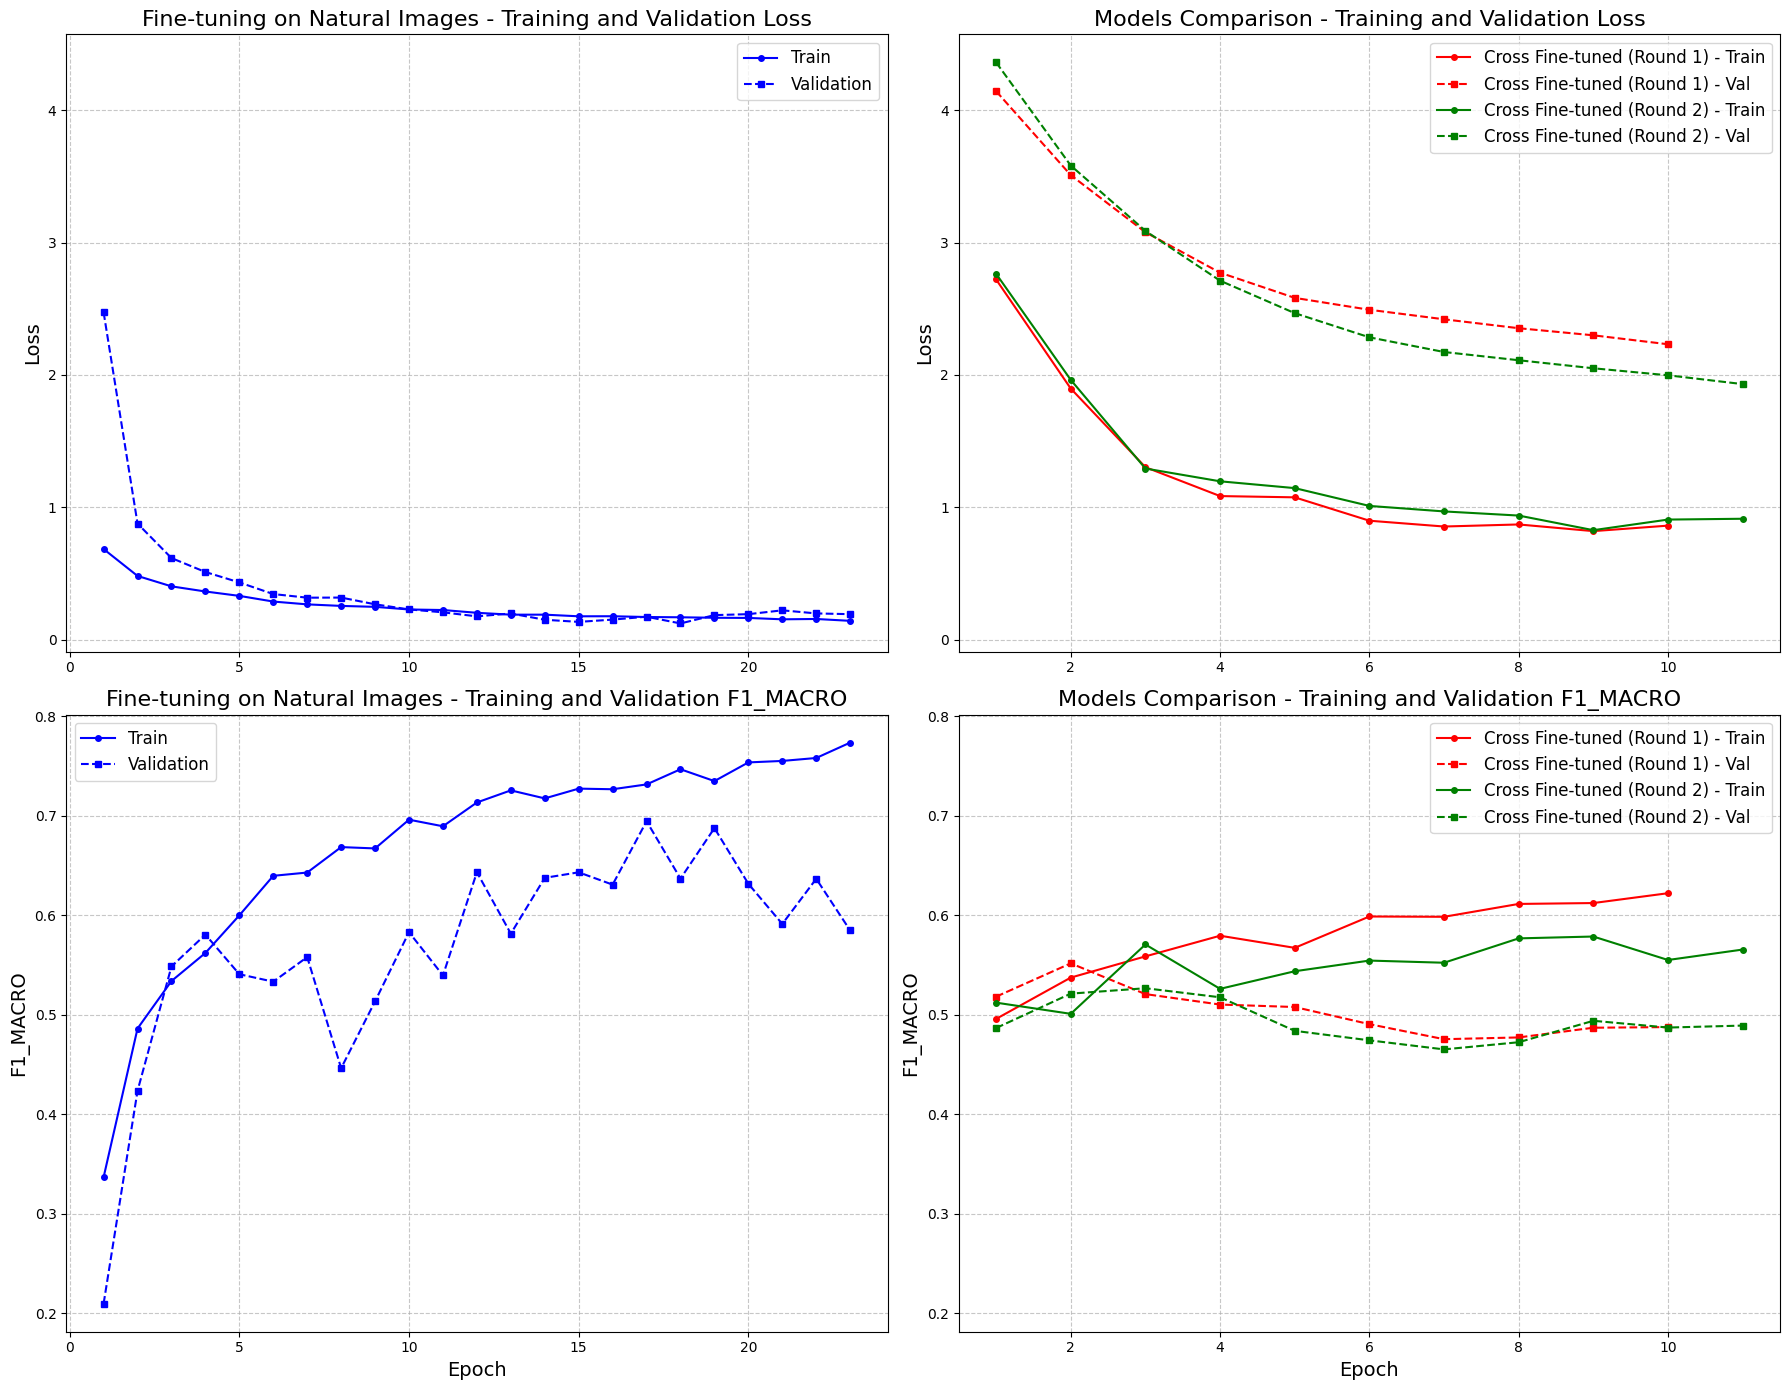

In [ ]:
history_files = [config.MODEL_DIR / "finetune_orig_history.csv",
                 config.MODEL_DIR / "finetune_cross_round_1_history.csv",
                 config.MODEL_DIR / "finetune_cross_round_2_history.csv"
]
labels = ["Fine-tuning on Natural Images", "Cross Fine-tuned (Round 1)", "Cross Fine-tuned (Round 2)"]
fig = plot_training_histories(history_files, labels, metric_name='f1_macro')

In [4]:
test_generator = create_regular_generator(TEST_DIR, with_augment=False, shuffle=False)
class_names = list(test_generator.class_indices.keys())
y_true = test_generator.classes

model_paths = [MODEL_DIR / "finetune_orig_best.h5",
               MODEL_DIR / "finetune_cross_round_2.h5"]
y_prob = []
y_pred = []
for path in model_paths:
    model = load_model_from_path(path)
    y_prob_ = model.predict(test_generator)
    y_prob.append(y_prob_)
    y_pred.append(np.argmax(y_prob_, axis=1))

Found 1121 images belonging to 7 classes.
Loading model from /home/matthias/projects/all-skin-deep/models/finetune_orig_best.h5


2025-04-25 13:10:17.268761: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/matthias/miniconda3/envs/disc/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step
Loading model from /home/matthias/projects/all-skin-deep/models/finetune_cross_round_2.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step


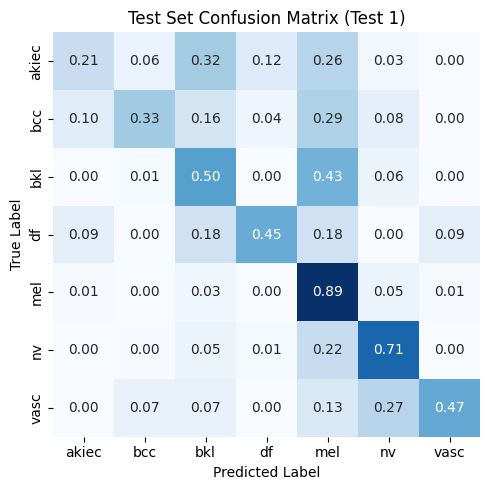

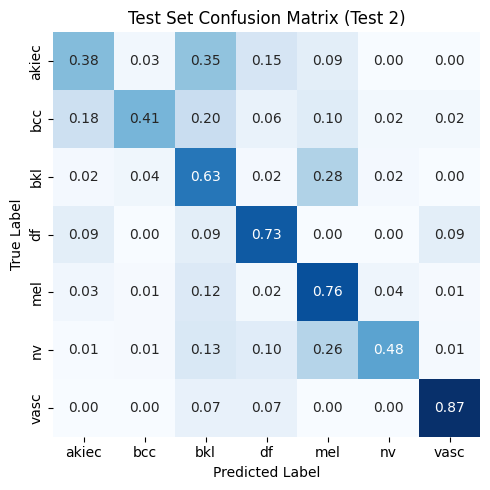

In [5]:
# Plot confusion matrix
for ind in range(2):
    cm = confusion_matrix(y_true, y_pred[ind])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize by row (i.e., by the actual class)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
    plt.title(f'Test Set Confusion Matrix (Test {ind+1})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f"confusion_matrix_test_{ind+1}.png"), dpi=200)

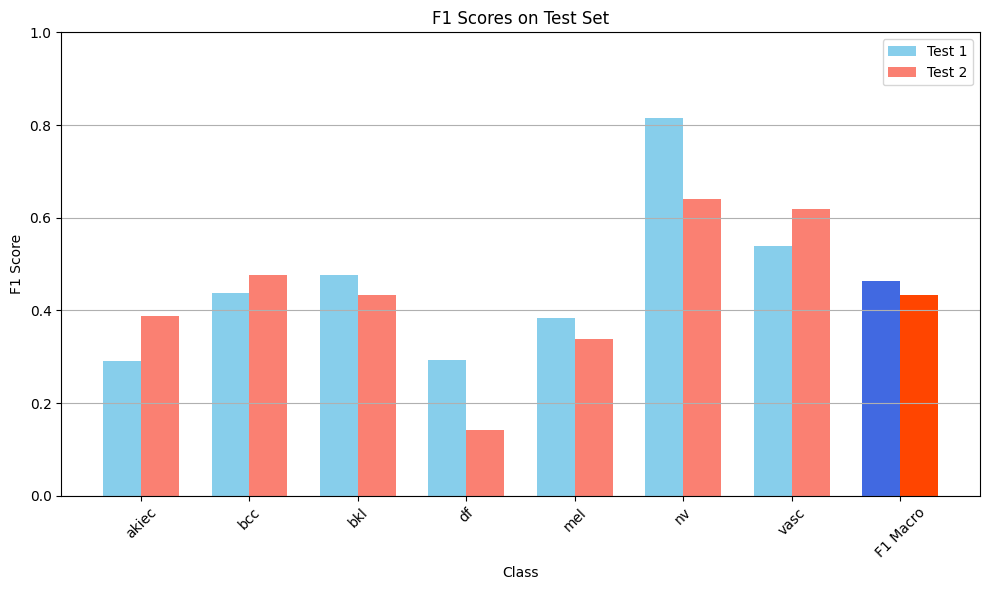

In [6]:
# Compute per-class F1 + macro for each model
all_f1_scores = []
labels = [f"Test {i+1}" for i in range(len(y_pred))]
colors = ['skyblue', 'salmon']                   # Bar colors per model
highlight_colors = ['royalblue', 'orangered']    # Macro bar colors per model

for y_pred_stage in y_pred:
    class_report = classification_report(y_true, y_pred_stage, target_names=class_names, output_dict=True)
    f1_scores = [class_report[class_name]['f1-score'] for class_name in class_names]
    f1_macro = np.mean(f1_scores)
    f1_scores.append(f1_macro)  # Add macro as 8th bar
    all_f1_scores.append(f1_scores)

# Convert to array for easier plotting
all_f1_scores = np.array(all_f1_scores)  # shape: (num_models, 8)
num_models, num_bars = all_f1_scores.shape
bar_width = 0.35
x = np.arange(num_bars)
extended_class_names = class_names + ['F1 Macro']

# Plot
plt.figure(figsize=(10, 6))

for i in range(num_models):
    # Set per-bar color list: all regular bars in model color, macro bar in highlight color
    bar_colors = [colors[i]] * (num_bars - 1) + [highlight_colors[i]]
    plt.bar(x + i * bar_width, all_f1_scores[i], width=bar_width, label=labels[i], color=bar_colors)

# Format
plt.xticks(x + bar_width * (num_models - 1) / 2, extended_class_names, rotation=45)
plt.ylabel("F1 Score")
plt.xlabel("Class")
plt.ylim(0, 1.0)
plt.title("F1 Scores on Test Set")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()

# Save
plt.savefig(os.path.join(PLOT_DIR, "f1_scores_with_macro_highlighted.png"), dpi=200)
plt.show()

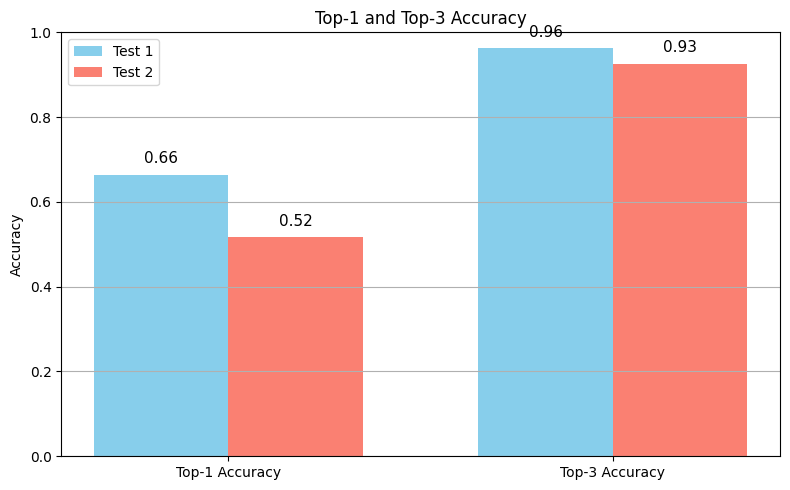

In [7]:
# Setup
stage_labels = ["Test 1", "Test 2"]
metric_labels = ["Top-1 Accuracy", "Top-3 Accuracy"]
colors = ['skyblue', 'salmon']  # Stage 1 = blue, Stage 2 = red

# Convert y_true once
y_true_categorical = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

# Collect accuracies
top1_list = []
top3_list = []

for y_prob_i in y_prob:
    y_prob_tensor = tf.convert_to_tensor(y_prob_i)
    top1 = categorical_accuracy(y_true_categorical, y_prob_tensor).numpy().mean()
    top3 = top_k_categorical_accuracy(y_true_categorical, y_prob_tensor, k=3).numpy().mean()
    top1_list.append(top1)
    top3_list.append(top3)

# Prepare data: rows = metrics, columns = stages
accuracy_data = np.array([top1_list, top3_list])  # shape (2, num_stages)
x = np.arange(len(metric_labels))
bar_width = 0.35

plt.figure(figsize=(8, 5))

# Plot each stage
for i in range(len(stage_labels)):
    plt.bar(x + i * bar_width, accuracy_data[:, i],
            width=bar_width, color=colors[i], label=stage_labels[i])
    # Add annotations
    for j in range(len(metric_labels)):
        value = accuracy_data[j, i]
        plt.text(x[j] + i * bar_width, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=11)

# Format
plt.xticks(x + bar_width / 2, metric_labels)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Top-1 and Top-3 Accuracy")
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()

# Save
plt.savefig(os.path.join(PLOT_DIR, "top_1_3_accuracy_grouped_by_metric.png"), dpi=200)
plt.show()